# LUNG CANCER DETECTION 

In [1]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import categorical_accuracy,categorical_crossentropy, top_k_categorical_accuracy
from keras import backend as k
from keras.layers.convolutional import*
import os
import tensorflow as tf
import random as rn
from matplotlib import pyplot as plt
import itertools
from keras.models import Model
import matplotlib.pyplot as plt
from keras.optimizers import Adam,RMSprop
%matplotlib inline
import json

Using TensorFlow backend.


In [2]:
tf.keras.backend.clear_session()

In [5]:
#CREATING VARIABLES AND ASSIGNING PATH
train_path='D:/Sahana/New_Segment/train'
valid_path='D:/Sahana/New_Segment/valid'
test_path='D:/Sahana/New_Segment/test'

In [6]:
train_batches=ImageDataGenerator().flow_from_directory(train_path,target_size=(224,224),classes=['0','1'],batch_size=10)
valid_batches=ImageDataGenerator().flow_from_directory(valid_path,target_size=(224,224),classes=['000','111'],batch_size=5)
test_batches=ImageDataGenerator().flow_from_directory(test_path,target_size=(224,224),classes=['11'],batch_size=1)

Found 1082 images belonging to 2 classes.
Found 218 images belonging to 2 classes.
Found 1 images belonging to 1 classes.


In [5]:
#FUNCTION TO DISPLAY THE IMAGES
#plot image with labels
def plots(ims,figsize=(12,6),rows=1,interp=False,titles=None):
    if type(ims[0]) is np.ndarray:
        ims=np.array(ims).astype(np.uint8)
        if(ims.shape[-1]!=3):
            ims=ims.transpose((0,2,3,1))
    f=plt.figure(figsize=figsize)
    cols=len(ims)//rows if len(ims) %2==0 else len(ims)//rows+1
    for i in range(len(ims)):
        sp=f.add_subplot(rows,cols,i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i],fontsize=16)
        plt.imshow(ims[i],cmap="CMRmap",interpolation=None if interp else 'none')

In [6]:
imgs,labels=next(train_batches)

FEW IMAGES OF TRAINING DATASET


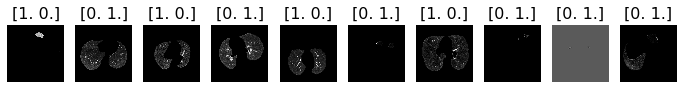

In [8]:
#we call the function plot to display images
print("FEW IMAGES OF TRAINING DATASET")
plots(imgs, titles=labels)

FEW IMAGES OF VALID DATASET


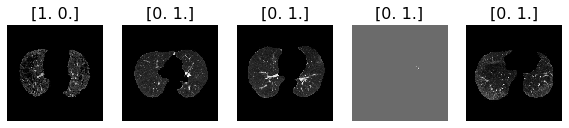

In [9]:
imgs1,labels1=next(valid_batches)
print("FEW IMAGES OF VALID DATASET")
plots(imgs1, titles=labels1)

In [10]:
import time

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


In [11]:
time_callback = TimeHistory()

In [12]:
import json
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

In [13]:
from tensorflow.keras.applications import MobileNet

In [14]:
from tensorflow.keras import layers 

In [15]:
from tensorflow.keras.optimizers import RMSprop

In [16]:
base_model = MobileNet(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [17]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [18]:
for layer in base_model.layers:
    layer.trainable = False

In [19]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(2, activation='softmax')(x)



In [20]:
model = tf.keras.models.Model(base_model.input, x)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [22]:
model.compile(tf.keras.optimizers.Adam(lr=.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [23]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=2,
                                  verbose=1,factor=0.2)

filepath="MobileNet_weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history= model.fit(train_batches, steps_per_epoch=108,
                              validation_data=valid_batches,validation_steps=44,epochs=25,verbose=1,
                              callbacks=[learn_control, checkpoint,time_callback]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 108 steps, validate for 44 steps
Epoch 1/25
107/108 [============================>.] - ETA: 0s - loss: 1.7387 - accuracy: 0.6977
Epoch 00001: val_accuracy improved from -inf to 0.65596, saving model to MobileNet_weights_best.hdf5
108/108 [==============================] - 14s 128ms/step - loss: 1.7237 - accuracy: 0.6996 - val_loss: 1.9484 - val_accuracy: 0.6560
Epoch 2/25
107/108 [============================>.] - ETA: 0s - loss: 0.4863 - accuracy: 0.8785
Epoch 00002: val_accuracy improved from 0.65596 to 0.71560, saving model to MobileNet_weights_best.hdf5
108/108 [==============================] - 12s 108ms/step - loss: 0.4819 - accuracy: 0.8797 - val_loss: 0.8921 - val_accuracy: 0.7156
Epoch 3/25
107/108 [============================>.] - ETA: 0s - loss: 0.2309 - accuracy: 0.9303
Epoch 00003: val_accuracy did not improve from 0.71560
108/108 [==============================] - 5s 50ms/step - loss: 0.2287 - accuracy: 0.9310 -

In [24]:
sum(time_callback.times)

212.00473022460938

In [25]:
import pandas as pd

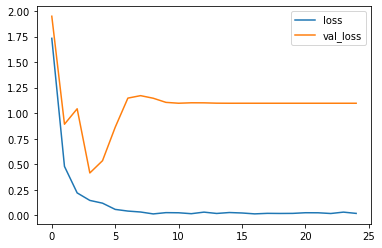

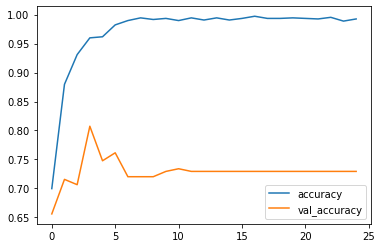

In [26]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()


In [31]:
test_batches=ImageDataGenerator().flow_from_directory(test_path,target_size=(224,224),classes=['11'],batch_size=1)

Found 1 images belonging to 1 classes.


1/1 [==============================] - 0s 16ms/step


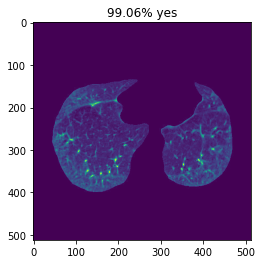

In [33]:
import matplotlib.image as mpimg
# Predicting

probabilities =model.predict_generator(test_batches, steps=1,verbose=1)
for index, probability in enumerate(probabilities):
    image_path = test_path + "/" +test_batches.filenames[index]
    img = mpimg.imread(image_path)
    plt.imshow(img)
    if probability[0] > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% no")
    
    else:
        plt.title("%.2f" % ((probability[1])*100) + "% yes")
    plt.show()

# LOADING AND TESTING MODEL

In [7]:
from tensorflow.keras.models import load_model

In [8]:
model=load_model('MobileNet_weights_best.hdf5')

In [9]:
results = model.evaluate(train_batches)
print("Training set of Images")
print('loss, accuracy', results)

  ...
    to  
  ['...']
109/109 [==============================] - 9s 79ms/step - loss: 0.4380 - accuracy: 0.7948
Training set of Images
loss, accuracy [0.43798778903320296, 0.7948244]


In [10]:
results1 = model.evaluate(valid_batches)
print("Validating set of Images")
print('loss, accuracy', results1)

  ...
    to  
  ['...']
44/44 [==============================] - 2s 41ms/step - loss: 0.4139 - accuracy: 0.8073
Validating set of Images
loss, accuracy [0.4139153721996329, 0.80733943]


In [11]:
test_batches=ImageDataGenerator().flow_from_directory(test_path,target_size=(224,224),classes=['1'],batch_size=1)

Found 1 images belonging to 1 classes.


1/1 [==============================] - 0s 11ms/step


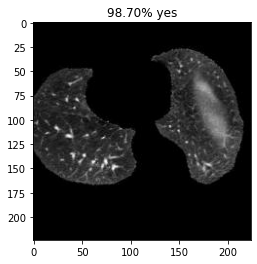

In [13]:
import matplotlib.image as mpimg
# Predicting

probabilities =model.predict(test_batches, steps=1,verbose=1)
for index, probability in enumerate(probabilities):
    image_path = test_path + "/" +test_batches.filenames[index]
    img = mpimg.imread(image_path)
    plt.imshow(img,cmap="Accent")
    if probability[0] > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% no")
    
    else:
        plt.title("%.2f" % ((probability[1])*100) + "% yes")
    plt.show()

In [16]:
test_batches=ImageDataGenerator().flow_from_directory(test_path,target_size=(224,224),classes=['0'],batch_size=1)

Found 1 images belonging to 1 classes.


1/1 [==============================] - 0s 36ms/step


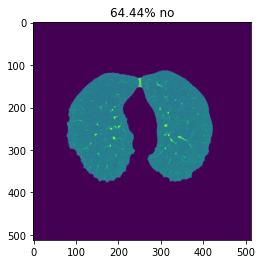

In [17]:
import matplotlib.image as mpimg
# Predicting

probabilities =model.predict(test_batches, steps=1,verbose=1)
for index, probability in enumerate(probabilities):
    image_path = test_path + "/" +test_batches.filenames[index]
    img = mpimg.imread(image_path)
    plt.imshow(img)
    if probability[0] > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% no")
    
    else:
        plt.title("%.2f" % ((probability[1])*100) + "% yes")
    plt.show()